In [1]:
# from utils import * 

import os
os.chdir("../../scVI/")
os.getcwd()

import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
import gseapy as gp

save_path = '../CSF/Notebooks/'

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt


In [3]:
%matplotlib inline

In [4]:
celllabels = np.load(save_path + 'meta/celllabels.npy')
celltypes, labels = np.unique(celllabels,return_inverse=True)

In [5]:
# latent_u = np.load(save_path + 'UMAP/all_dataset.umap.npy')
# with open(save_path + 'dataset/all_datasets.pkl', 'rb') as f:
#     gene_dataset = pickle.load(f)

# logX = np.log10(1+gene_dataset.X.todense())
# scaling_factor = logX.mean(axis=1)
# norm_X = logX - scaling_factor.reshape(len(scaling_factor), 1)

isMS = np.load(save_path+'meta/isMS.npy')
isCSF = np.load(save_path+'meta/isCSF.npy')

In [6]:
# with open(save_path + 'DE/control_tissue.DEres.pkl', 'rb') as f:
#     tissueDE,tissueDEclust = pickle.load(f)

In [7]:
# clean = [1,2,3,4,5,6,7,8,10,11,13,14,17,18,19,20,21]
# temp=[x in clean for x in tissueDEclust]
# DEres = [tissueDE[i] for i,x in enumerate(temp) if x is True]
# DEclust = [tissueDEclust[i] for i,x in enumerate(temp) if x is True]
# genenames = pd.read_csv('../CSF/RFiles/genenames.csv',header=None)


In [8]:
# celltype = []
# combinedDEres = []
# for i,x in enumerate(celltypes[DEclust]):
#     temp  = pd.read_csv('../CSF/DE/wilcoxon/MannWhitneyU.norm.tissue_control.%s.csv'%x)
#     fdr_wil = multipletests(temp['pvalue'],method='fdr_bh')
#     temp.index = list(genenames[0])
#     temp = pd.concat([temp,DEres[i]],axis=1,sort=True)
#     temp = temp.sort_values(by='bayes1',ascending=False)
#     combined = deepcopy(temp[['stat','pvalue','bayes1','bayes2','mean1','mean2','nonz1','nonz2','clusters']])
#     combined['scVI_logFC'] = np.log(temp['scale1']/temp['scale2'])
#     combined['norm_logFC'] = np.log(temp['norm_mean1']/temp['norm_mean2'])
#     temp  = pd.read_csv('../CSF/EdgeR/tissue_control.batch_corrected.%s.edgeR.csv'%x)
#     fdr_edgeR = multipletests(temp['PValue'],method='fdr_bh')
#     temp.index = list(genenames[0])
#     temp = temp[['logFC','logCPM','F','PValue']]
#     combined = pd.concat([combined,temp],axis=1,sort=True)
#     combined['fdr_wil'] = fdr_wil[1]
#     combined['fdr_edgeR'] = fdr_edgeR[1]
#     celltype.append(x)
#     combinedDEres.append(combined)

    
# with open(save_path + 'DE/tissue_control.combined.DEres.pkl', 'wb') as f:
#     pickle.dump((combinedDEres,celltype),f)

In [9]:

with open(save_path + 'DE/tissue_control.combined.DEres.pkl', 'rb') as f:
    combinedDEres,celltype = pickle.load(f)

In [11]:
# from pandas import ExcelWriter
# import xlsxwriter


# writer = pd.ExcelWriter(save_path + 'DE/tissue_control.xlsx', engine='xlsxwriter')
# for i, x in enumerate(celltype):
#     combinedDEres[i].to_excel(writer, sheet_name=str(x))
# writer.close()


In [12]:
celltype

['B2',
 'CD4',
 'CD8a',
 'CD8n',
 'Gran',
 'NK1',
 'NK2',
 'Tdg',
 'Tregs',
 'mDC2',
 'ncMono',
 'pDC']

# DE measure correlation between clusters

In [13]:
combinedDEres[0].columns

Index(['stat', 'pvalue', 'bayes1', 'bayes2', 'mean1', 'mean2', 'nonz1',
       'nonz2', 'clusters', 'scVI_logFC', 'norm_logFC', 'logFC', 'logCPM', 'F',
       'PValue', 'fdr_wil', 'fdr_edgeR'],
      dtype='object')

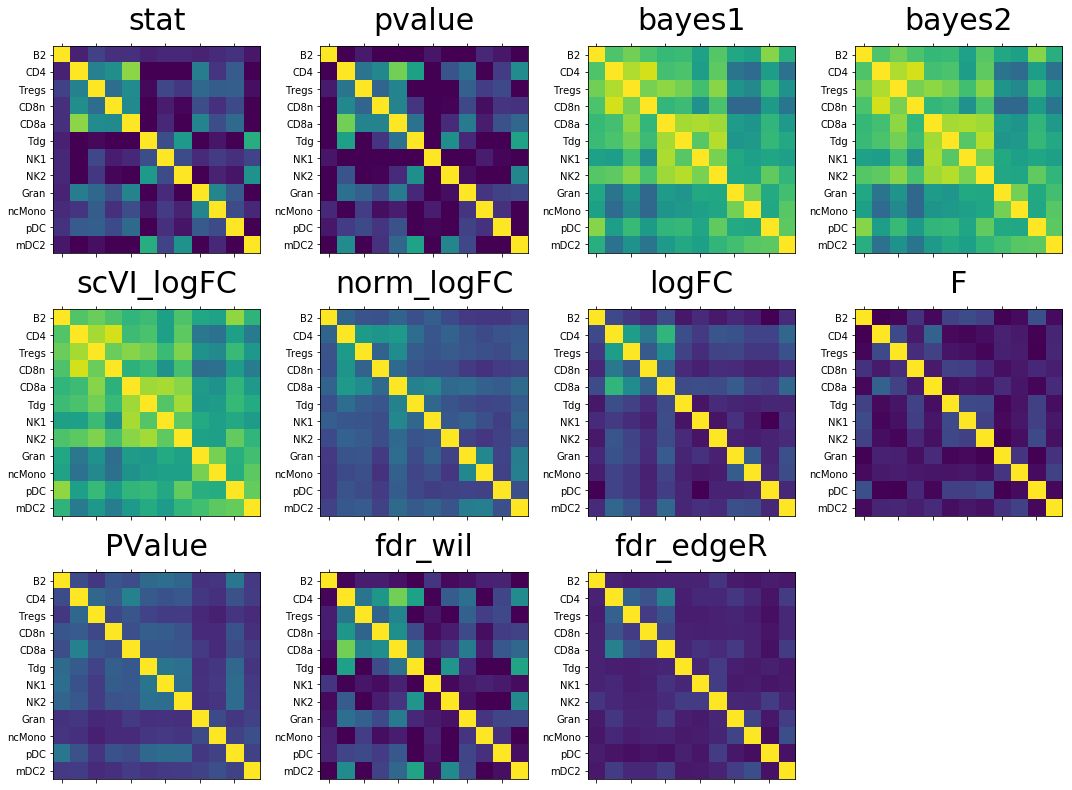

In [41]:
plt.figure(figsize=(15,15))
corr = []
for k, stat in enumerate(['stat','pvalue','bayes1','bayes2','scVI_logFC','norm_logFC','logFC','F','PValue','fdr_wil','fdr_edgeR']):
    df = pd.concat([x[stat] for x in combinedDEres],axis=1)
    df.columns = celltype
    df = df[['B2','CD4','Tregs','CD8n','CD8a','Tdg','NK1','NK2','Gran','ncMono','pDC','mDC2']]
    ax = plt.subplot(4,4,(k+1))
    res = df.corr(method='spearman')
    corr.append(res)
    ax.matshow(res,vmin=0,vmax=1)
    plt.title(stat,fontsize=30)
    plt.xticks(color='w')
    plt.yticks(range(len(df.columns)), df.columns)
    plt.tight_layout()

plt.savefig(save_path + 'figures/SupFigure10/CSF_blood.DEcor.pdf')


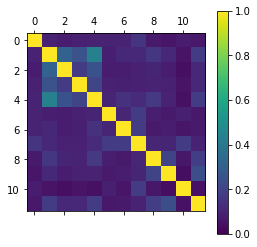

In [42]:
plt.matshow(res,vmin=0,vmax=1)
plt.colorbar()
plt.savefig(save_path + 'figures/SupFigure10/CSF_blood.colorbar.pdf')

In [15]:
# from pandas import ExcelWriter
# import xlsxwriter


# writer = pd.ExcelWriter(save_path + 'DE/MSinCSF.xlsx', engine='xlsxwriter')
# for i, x in enumerate(celltype):
#     combinedDEres[i].to_excel(writer, sheet_name=str(x))
# writer.close()


# GSEA

In [26]:
gmt = ['c7.all.v6.2.symbols.gmt',
       'Hemato.geneset.gmt',
       'cell_cycle_Tirosh.gmt',
       'chenling.gmt',
       'netPath.gmt',
       'codeset.gmt',
       'signatures_NY_private.gmt']
gmt = ['../CSF/signatures/unmodified/'+x for x in gmt]

In [29]:
def DE_GSEA(filtered,gmt,celltypes,filename):
    gsea_res = []
    for x in filtered:
        if len(x)>0:
            res1 = gp.enrichr(gene_list=list(x.index),
                     gene_sets=['KEGG_2016'],
                     cutoff=0.5                    )
            res2 = gp.enrichr(gene_list=list(x.index),
                             gene_sets=gmt,
                             cutoff=0.5,
                             background=10266)
            res = pd.concat([res1.results,res2.results])
            res = res.sort_values(by='P-value')
            res['cluster'] = celltypes[list(x['clusters'])[0]]
            gsea_res.append(res.loc[res['Adjusted P-value']<0.05])
    gsea_res = pd.concat(gsea_res)
    gsea_res = gsea_res[['Adjusted P-value','Genes','Term','Overlap','cluster']]
#     gsea_res.to_csv(filename)
    return(gsea_res)


# upregulated in CSF

In [16]:
filtered = [x.loc[(x['fdr_wil']<0.2)&(x['fdr_edgeR']<0.2)& 
                  (x['bayes1']>0.3) &
                  (x['logFC']<0) & (x['norm_logFC']>0)] for x in combinedDEres]

DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)

DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes = DEgenes.sort_index()
# DEgenes.to_csv(save_path+'DE/control_tissue.upregulated.relaxed.csv')

In [22]:
DEgenes.loc[['FGF9','MT1E']]

,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR
FGF9,11447686.0,3.500782e-162,1.248904,-1.255700,0.00548,0.00164,0.00520,0.00164,CD4,0.390715,1.244018,-0.105166,9.233607,2.070925e+02,0.005194,7.513653e-174,3.330119e-118
FGF9,47342.0,1.182700e-01,2.147607,-2.142172,0.03328,0.00472,0.03328,0.00472,CD8n,0.549224,1.919024,-0.000827,9.165923,1.913665e-07,0.999894,6.346709e-02,1.579450e-01
FGF9,2672065.0,4.022326e-40,1.752557,-1.755976,0.00360,0.00112,0.00360,0.00112,CD8a,0.794181,1.002539,-0.036213,9.658619,4.042713e+01,0.224931,8.232342e-51,4.794033e-39
FGF9,51768.0,5.445594e-19,3.718294,-3.720025,0.01796,0.00236,0.01796,0.00236,Tdg,0.970922,2.331484,-0.348039,9.455692,2.303296e+00,0.583617,5.418580e-06,4.889590e-15
FGF9,30822.0,4.548477e-28,4.861425,-4.816507,0.01112,0.00000,0.01112,0.00000,mDC2,1.587063,inf,-0.135079,8.237051,1.846681e+00,0.670917,3.608143e-10,1.509575e-02
FGF9,225184.0,4.115212e-08,5.019415,-5.047397,0.00824,0.00000,0.00824,0.00000,Gran,1.381743,inf,-0.159619,9.133868,1.749615e+01,0.182605,2.416485e-02,4.717353e-12
MT1E,149910.0,5.702738e-03,0.451812,-0.456148,0.19124,0.19324,0.10388,0.09460,Tregs,0.100541,0.158621,-0.723608,9.352579,7.421747e+00,0.006539,4.606100e-11,2.229370e-08
MT1E,12731725.0,1.747524e-87,1.686930,-1.698777,0.09204,0.01356,0.07036,0.01324,CD4,0.798589,1.828907,-0.040736,9.268764,1.905941e+00,0.461190,4.326982e-110,3.394541e-48
MT1E,232671.0,1.460868e-06,0.959367,-0.967145,0.09788,0.06412,0.07012,0.05800,Gran,0.446360,0.182664,-0.028186,9.181581,1.688003e+00,0.451002,4.329937e-20,4.189014e-04
MT1E,42350.0,3.489796e-01,2.647391,-2.660578,0.38504,0.03756,0.13080,0.02520,ncMono,1.309251,2.341227,-0.626574,8.750900,1.047355e+00,0.306344,5.054218e-21,3.411516e-06


In [26]:
DEgenes.loc[['CD1E','CCNC','CXCL16','CXCR5','CD48']]

,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR
CD1E,11376111.0,4.992866e-167,1.103739,-1.108584,0.00108,0.00000,0.00108,0.00000,CD4,0.563740,inf,-0.010309,9.231148,74.812299,3.527367e-01,8.845839e-165,0.023553
CCNC,12667015.0,1.077284e-90,0.969200,-0.971458,0.13828,0.11492,0.12828,0.10884,CD4,0.237240,0.152414,-0.767701,9.319984,107.641651,1.326025e-13,1.062376e-157,0.048373
CXCL16,11591519.0,1.159336e-152,1.427619,-1.428869,0.01224,0.00352,0.01188,0.00352,CD4,0.574683,1.139285,-0.019772,9.236353,8.000659,5.191783e-01,2.460630e-144,0.044404
CXCR5,11433109.0,3.656836e-163,0.342654,-0.340821,0.00644,0.00540,0.00612,0.00540,CD4,0.145140,0.127310,-0.041183,9.235371,69.490471,4.610032e-02,2.061918e-122,0.062742
CXCR5,2686291.0,1.208621e-38,1.056494,-1.063559,0.00604,0.00080,0.00576,0.00080,CD8a,0.472017,1.968735,-0.084375,9.659819,65.061052,5.811549e-02,5.769260e-20,0.020399
CD48,18833811.0,2.509757e-50,1.933443,-1.934122,2.26668,1.66812,0.85888,0.76852,CD4,0.282830,0.256677,-0.552000,10.228549,82.146098,1.469180e-19,2.229861e-52,0.007289


In [27]:
up = DEgenes

In [30]:
# %%capture
# filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/control_tissue.upregulated.relaxed.GSEA.csv')

In [31]:
filtered = [x.loc[(x['fdr_wil']<0.05)&(x['fdr_edgeR']<0.05)& 
                  (x['bayes1']>0.5) &
                  (x['logFC']<0) & (x['norm_logFC']>0)] for x in combinedDEres]

DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)

DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes = DEgenes.sort_index()
# DEgenes.to_csv(save_path+'DE/control_tissue.upregulated.csv')


# downregulated in MS

In [96]:

filtered = [x.loc[(x['fdr_wil']<0.2)&(x['fdr_edgeR']<0.2)& 
                  (x['bayes2']>0.3) &
                  (x['logFC']>0) & (x['norm_logFC']<0)] for x in combinedDEres]


DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)
DEgenes = DEgenes.sort_index()
DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]

# DEgenes.to_csv(save_path+'DE/control_tissue.downregulated.relaxed.csv')

In [97]:
down = DEgenes

In [16]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/control_tissue.downregulated.relaxed.GSEA.csv')

In [83]:
filtered = [x.loc[(x['fdr_wil']<0.05)&(x['fdr_edgeR']<0.05)& 
                  (x['bayes2']>0.5) &
                  (x['logFC']>0) & (x['norm_logFC']<0)] for x in combinedDEres]
DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)
DEgenes = DEgenes.sort_index()
DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
# DEgenes.to_csv(save_path+'DE/control_tissue.downregulated.csv')


In [104]:
filtered_GSEA

,Adjusted P-value,Genes,Term,Overlap,cluster
0,0.011222,GATM,"Glycine, serine and threonine metabolism_Homo ...",1/40,B2
1,0.011222,GATM,Arginine and proline metabolism_Homo sapiens_h...,1/50,B2
0,0.000212,YWHAE;HDAC5;PSMD11;YWHAB;ITGAL;GTF2E1;RELA;SPN...,Epstein-Barr virus infection_Homo sapiens_hsa0...,47/202,CD4
1,0.000478,ITPR2;XIAP;FASLG;RELA;ACTG1;IKBKB;MAPK9;TUBA1C...,Apoptosis_Homo sapiens_hsa04210,35/140,CD4
2,0.000518,SRSF1;CUL1;FASLG;RELA;PPP1CB;IKBKB;MAPK9;POLR2...,Herpes simplex infection_Homo sapiens_hsa05168,42/185,CD4
3,0.000549,NGLY1;CUL1;DERL1;RNF5;SEC61A1;MAPK9;ERLEC1;SSR...,Protein processing in endoplasmic reticulum_Ho...,39/169,CD4
5,0.001020,FASLG;IKBKB;MAPK9;STK11;AKT3;TNFSF10;S1PR1;EP3...,FoxO signaling pathway_Homo sapiens_hsa04068,32/133,CD4
4,0.001020,RELA;IKBKB;MAPK9;CASP7;RPS6KA5;CASP10;CCL5;AKT...,TNF signaling pathway_Homo sapiens_hsa04668,28/110,CD4
6,0.001311,CBLB;FASLG;RELA;AKT3;TNFSF10;SLAMF1;IFNAR2;CHU...,Measles_Homo sapiens_hsa05162,32/136,CD4
7,0.003592,RASGRF2;FASLG;IKBKB;PPP3CB;RPS6KA5;FGF9;AKT3;P...,MAPK signaling pathway_Homo sapiens_hsa04010,49/255,CD4


In [18]:
%%capture
filtered_GSEA = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/control_tissue.downregulated.GSEA.csv')

In [102]:
allgenes = pd.concat(combinedDEres)

In [88]:
genes, occ = np.unique(allgenes.index,return_counts=True)

np.sum(occ==1)/10266

0.18936294564582115

In [89]:
np.sum(occ==2)/10266

0.05075004870446133

In [103]:
allgenes.loc[['CCNC']]

,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR
CCNC,3820.0,9.527629e-01,1.038161,-1.035677,0.16156,0.07956,0.12148,0.07656,2,0.251276,0.852185,0.233718,9.305480,4.020649e-01,6.966381e-01,9.991406e-01,1.000000
CCNC,12667015.0,1.077284e-90,0.969200,-0.971458,0.13828,0.11492,0.12828,0.10884,3,0.237240,0.152414,-0.767701,9.319984,1.076417e+02,1.326025e-13,1.062376e-157,0.048373
CCNC,2841957.0,2.405322e-24,0.594513,-0.598880,0.11184,0.09080,0.10668,0.08444,4,0.159227,0.091278,-0.664069,9.729069,5.309769e+01,8.950852e-07,9.653269e-38,0.676739
CCNC,49667.0,3.868982e-01,0.930171,-0.943222,0.15588,0.12056,0.15588,0.11340,5,0.222664,0.305971,-0.861958,9.246196,5.620311e+00,9.315288e-02,1.713253e-01,1.000000
CCNC,243690.0,1.273933e-04,2.334509,-2.336311,0.14424,0.10420,0.12412,0.09436,6,0.443582,0.085781,-0.358462,9.207436,5.309210e+00,1.211276e-01,2.799287e-08,0.508975
CCNC,10866.0,9.092227e-01,1.061227,-1.062327,0.04660,0.09964,0.04660,0.09124,10,0.232024,-1.225172,-0.063224,10.004901,2.667500e-10,9.999870e-01,9.947061e-01,1.000000
CCNC,6438.0,3.752142e-03,0.525316,-0.526901,0.13464,0.09896,0.11832,0.09228,11,0.137821,0.088695,0.248857,9.377245,1.624252e-01,8.184308e-01,1.715405e-02,1.000000
CCNC,49326.0,3.169905e-14,0.019781,-0.017480,0.15368,0.13168,0.15368,0.12860,13,0.069188,0.243474,-1.011192,9.545419,2.068297e+00,2.955909e-01,7.203383e-18,1.000000
CCNC,149067.0,3.576600e-03,0.391962,-0.384280,0.13476,0.15268,0.12608,0.14132,14,0.116422,-0.128017,-0.754950,9.322818,8.100769e+00,3.927977e-02,1.150616e-02,0.843815
CCNC,25329.0,2.827976e-10,0.693612,-0.697756,0.25584,0.30596,0.22880,0.25456,18,0.158220,0.169055,-0.257474,8.409595,1.781527e-01,7.149273e-01,3.240954e-27,0.874885
